# Proyecto 4: Analizar el comportamiento del Mercado Inmoviliario 

Este Proyecto tiene como finalidad evaluar el funcionamiento de un nuevo Modelo de Machine Learning diferente a los utilizados en el Proyecto 1y 2 para calcular el valor de cualquier inmueble considerando se georeferenciación. Se tiene previsto concentrar esfuerzos para predecir el precio de cualquier propiedad inmoviliario en cualquier punto del espacio, para ello se representarán cada uno de los datos disponibles en el dataset en un mapa (una vez filtrados).


## Objetivo

Probar el desempeño de un nuevo modelo de Machine Learning para predecir el precio de cualquier Propiedad en las principales provincias de Argentina en función de su localización  geográfica.

Analizar la distribución espacial de los errores de predicción


https://github.com/Elacarrascal/Proyecto-Acamica-4

## Preguntas a responder en el Proyecto

### 1.  Se pide preprocesar los datos originales y hacer un mapa tomando en cuanta la distribución de las propiedades inmoviliarias en el espacio (analizar solo Buenos Aires)




Primeramente se importan las librerias o dependencias

In [1]:
# Se importa la libreria para evitar mostrar warning en el notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
# librerias para general el mapa
import folium
from folium.plugins import HeatMap #importar modulo de mapa de calor
#Validacion cruzada
from sklearn.model_selection import cross_val_score
# importar el modulo del nuevo Algoritmo
from sklearn.ensemble import RandomForestRegressor
#importar módulo Skl
from sklearn.model_selection import train_test_split
# Importa el modulo de calculo del rmse
from sklearn.metrics import mean_squared_error

In [2]:
# La siguiente línea es para ver las imagenes dentro del notebook
%matplotlib inline
# Configuramos el tamaño de las figuras
plt.rcParams['figure.figsize'] = (13,9)

Se Carga el dataset original:

In [3]:
# Leer usando Pandas
df = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv", parse_dates = ["created_on"])

Se hace una rutina para eliminar las celdas que no tengas datos, se prioriza los atributos (latitud y longitud) y al final del código se imprime cuantos registros fueron eliminados del fichero original

In [4]:
# Antes de seguir Vamos a Verificar si existe algun registro sin datos

# aqui leemos las dimensiones del DataFrame original
(registros_antes,columnas_antes)=(df.shape)

# eliminar los registros sin datos validos
df.lon = df.lon.replace(['NA'],np.nan)
df = df[~df.lon.isna()]

# aqui leemos las dimensiones del DataFrame modificado
(registros_despues,columnas_despues)=(df.shape)

# Comparar la cantidad de registros antes y despues
print('')
if registros_antes==registros_despues:
    print('MENSAJE: El DataFrame de Reviews no requiere ser depurado por Registros')
else:
    print('MENSAJE: Fueron eliminados ',registros_antes-registros_despues,'registros del DataFrame Original')



MENSAJE: Fueron eliminados  9959 registros del DataFrame Original


Vamos a imprimir cuantas clases hay (provincias) en el dataframe depurado porque eso nos sirve para ver que tan grande es la cantidad de datos de la Provincia en cuestión y el resto de las Provincias.

In [5]:
df['l2'].value_counts()

Capital Federal             87931
Bs.As. G.B.A. Zona Norte    20730
Bs.As. G.B.A. Zona Sur      16202
Bs.As. G.B.A. Zona Oeste    11838
Name: l2, dtype: int64

Ahora nos toca implementar un Filtro solo con las propiedades que esten ubicadas en Buenas Aires "CAPITAL FEDERAL" y crear un DataFrame que se llame df1

In [6]:
#Filtro para provincias
df1=df[df['l2']=='Capital Federal']
print('Nuestro datasets solo con la Provincia de Buenas Aires tiene', df1.shape[0],' registros')


Nuestro datasets solo con la Provincia de Buenas Aires tiene 87931  registros


Ahora nos queda construir un gráfico inicial que nos diga como es la distribuciòn en el espacio (tipo Mapa) de nuestros puntos. Para ello, haremos un grafico de dispersión o scatterplot colocando en el eje x (longitud) y en el eje y (latitud)

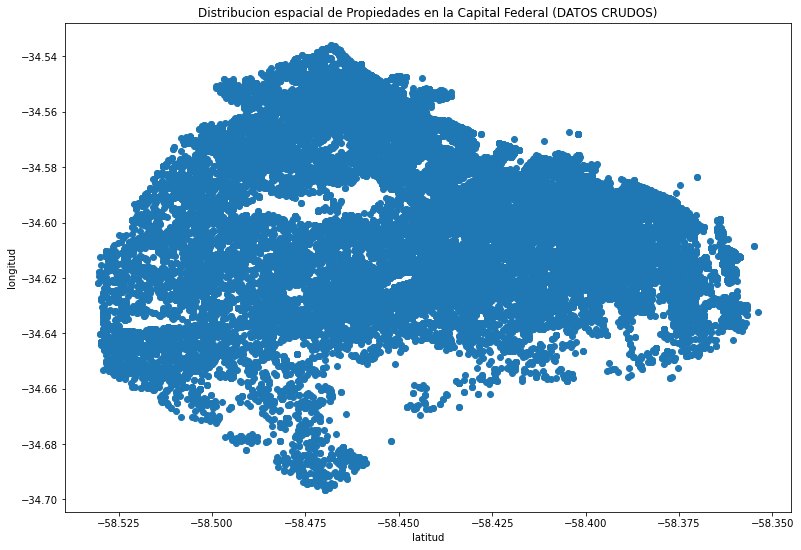

In [7]:
# Crear los conjuntos de coordenadas a plotear
y=df1['lat']
x=df1['lon']

# Definir el tipo de Gràfico
plt.scatter(x,y)
plt.xlabel('latitud');plt.ylabel('longitud')
plt.title('Distribucion espacial de Propiedades en la Capital Federal (DATOS CRUDOS)')
plt.show()

Luego de aplicar filtros para eliminar celdas sin datos , se obtuvo el mapa de puntos que se muestra considerando solo la Provincia de Capital Federal, alli se muestra claramente como se distribuyen los datos y se aprecian zonas vacias o pobres (zona central y sur) en datos y algunas zonas de alta concentracion de datos donde por supuesto la calidad de la predicción deberia ser mayor.  La idea general es poder entrenar un modelo para predecir el precio de cualquier inmueble de esta Provincia, solamente ingresando las coordenadas (latitud y longitud) de dicho inmueble.

### 2.  Elaborar un mapa de Calor donde se aprecie las zonas donde existe mayor concentración de puntos y donde hay zonas con pocos datos

Vamos a usar la libreria Folium para crear un mapa web totalmente georeferenciado donde incluiremos los puntos que forman parte del dataset que ya hemos depurado previamente

In [8]:
# calculamos las coordenadas del centro del mapa
lat_centro_map=df1['lat'].mean() #promedio de las coordenadas latitud
lon_centro_map=df1['lon'].mean() #promedio de las coordenadas longitud

# creamos una pequeña lista con las coordenadas del centro del mapa
Capital_Federal_location = [lat_centro_map, lon_centro_map]

# Creamos el objeto m (mapa) y pasamos como parametros el centro y el zoom que queremos
m = folium.Map(location=Capital_Federal_location, zoom_start=14)

#Extraer los puntos de coordenadas de todos los inmuebles en una lista llamada datos
datos=[] # se crea la lista vacia
for x,y in zip(df1.iloc[:,3],df1.iloc[:,4]):
   datos.append([x,y])

# Se Crea el mapa de Calor y se añade al objeto mapa que ya habiamos creado
HeatMap(datos).add_to(m)

# Se imprime el mapa de calor resultante
m


Este mapa de calor es sumamente importante , ya que nos permite apreciar (hacer zoom) las areas donde tenemos buena cantidad de datos disponibles y las zonas donde es necesario recabar mas información sobre los precios. A continuación se deben analizar una vez mas datos y aplicar los procesos de depuración necesarios para entrenar el modelo de predicción.

### 3.  Construya el histograma de datos y aplique una rutina para eliminar outlier si hace falta

Vamos a calcular los parametros estadísticos (enfocados en las medidas de tendencia central), y a partir de alli y del analisis gráfico , aplicaremos un procedimiento de eliminacion de datos atípicos. 

In [9]:
# Primero calculamos los estadisticos de los datos

# calculamos la media
media = df1.price.mean()

# calculamos de desviacion
std = df1.price.std()

# calculamos el minimo usando 3 veces la desviacion 
minimo = media - 3*std

# calculamos el maximo usando 3 veces la desviacion 
maximo = media + 3*std

# guardamos los parametros en una lista
estadistica=[media,std,minimo, maximo]
names=['Valor Medio=','Desviacion=','Minimo=','Maximo=']

#impresion de estadisticas
print('Los parametros de dispersion son: ')
for nombre, dato in zip(names,estadistica):
    print(nombre,dato)
    
# Calculamos el coeficiente de Variacion para ver el grado de dispersion relativa
cv = df1["price"].std(ddof=0) / df1["price"].mean()
print('')
print('El coeficiente variacion es de :',cv)


Los parametros de dispersion son: 
Valor Medio= 254458.32026247855
Desviacion= 338052.6176621259
Minimo= -759699.5327238991
Maximo= 1268616.1732488563

El coeficiente variacion es de : 1.3285110702893046


Se aprecia claramente que la desviacion standard es considerable. Por otro lado, el coeficiente de variacion es bastante alto inclusive superior a 1, por lo tanto procedemos aplicar los filtros para eliminar outliers.

Veamos como es el histograma de frecuencias de nuestros datos.

Text(0, 0.5, 'FRECUENCIA price')

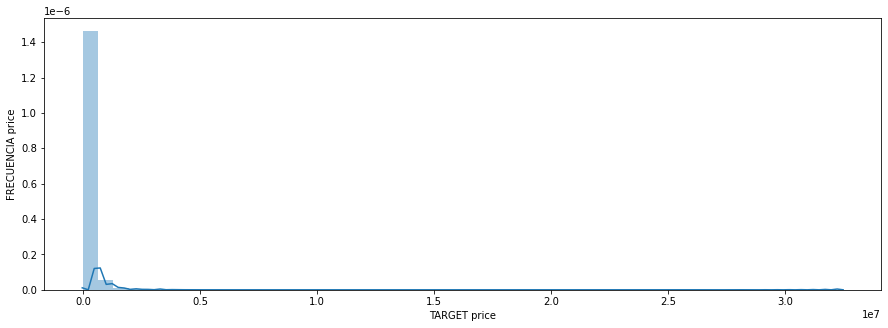

In [10]:
# Grafica de nuestros datos
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(df1.price)
ax.set_xlabel('TARGET price')
ax.set_ylabel('FRECUENCIA price')

Se nota claramente una asimetria fuerte en el histograma de datos, por eso vamos eliminar algunos puntos anomalos aplicando el siguiente método

Habian  87931 registros
Quedaron  86610 registros


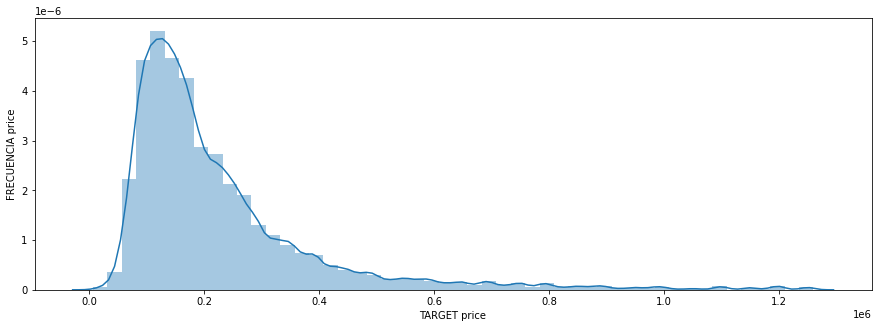

In [11]:
# AQui procedemos procedemos a construir una mascara para filtrar outliers

#finalmente este seria el dataFrame final
print('Habian ',df1.shape[0], 'registros')

# crear mascara
outliers_mask= df1.price < maximo
# Aplicar filtroal dataframe que tenemos
df1 = df1[outliers_mask]

# Procedemos a graficar el historgrama con el nuevo datasets
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(df1.price)
ax.set_xlabel('TARGET price')
ax.set_ylabel('FRECUENCIA price')

#finalmente este seria el dataFrame final
print('Quedaron ',df1.shape[0], 'registros')

Se vuelven a calcular los parámetros de dispersión, y se hace énfasis en el parametro coeficiente de variación. 

In [12]:
# Se vuelben a calcular los parametros

# calculamos la media
media = df1.price.mean()

# calculamos de desviacion
std = df1.price.std()

# calculamos el minimo usando 3 veces la desviacion 
minimo = media - 3*std

# calculamos el maximo usando 3 veces la desviacion 
maximo = media + 3*std

# guardamos los parametros en unalista
estadistica=[media,std,minimo, maximo]

names=['Valor Medio=','Desviacion=','Minimo=','Maximo=']

#impresion de estadisticas
print('Los parametros de dispersión son: ')
for nombre, dato in zip(names,estadistica):
    print(nombre,dato)

# Calculamos el coeficiente de Variacion para ver el grado de dispersion relativa
cv2 = df1["price"].std(ddof=0) / df1["price"].mean()
print('')
print('El coeficiente variacion es de :',cv2)

    

Los parametros de dispersión son: 
Valor Medio= 226417.65612515877
Desviacion= 173722.36859181302
Minimo= -294749.4496502803
Maximo= 747584.7619005978

El coeficiente variacion es de : 0.7672606839137674


Hagamos un grafico comparativo con los dos valores del coeficiente de variacion antes y despues del proceso de preprocesamiento

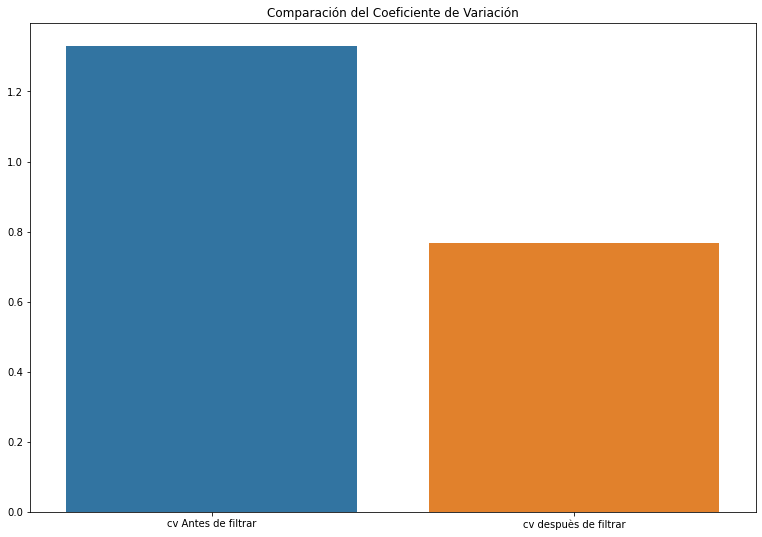

In [13]:
x = ['cv Antes de filtrar', 'cv despuès de filtrar']
y = [cv, cv2]

#Se genera la grafica de barras
sns.barplot(x, y).set_title('Comparación del Coeficiente de Variación')

plt.show()

La gráfica que ese muestra es evidencia clara de la importancia que tiene la eliminacion de datos atípicos en cualquier dataset. En este caso cobra mayor importancia ya que nos conviene que las variaciones de precios entre una y otra edificación, sea leve o uniforme en el espacio (como sucede en la realidad)y no ocurran variaciones tan abruptas en pequeñas distancias. En resumen, es mejor disponer de una base de datos que presente cierta sectorización espacial en función de los precios.

### 4.  Elabore un mapa donde se aprecie (con colores) como se distribuyen los precios inmoviliarios en Buenos Aires (inlcuir al menos 5 categorias para clasificar los datos por precio). Esto ayudará a identificar ¿ Cuáles son las zonas más abundantes en datos y cuáles son las zonas más pobres ?

Debemos crear un nuevo DataFrame con una nueva columna (rango) que tenga una categoria de precio facil de entender, tal como se muestra a continuacion. 

In [14]:
#Se crea el dataFrame
dataset=pd.DataFrame()

#Se asignan las columnas de geolocalizacion latitud y longitud de cada inmueble asi como el precio
dataset['lat']=df1['lat']
dataset['lon']=df1['lon']
dataset['price']=df1['price']

# El nuevo dataset es el siguiente
dataset.head()

lat        lon     price
0 -34.605880 -58.384949  153000.0
1 -34.624056 -58.412110  159000.0
2 -34.593569 -58.427474  125000.0
3 -34.581294 -58.436754  295000.0
5 -34.593779 -58.441239  150000.0

In [15]:
print('El maximo Precio de los inmuebles en Buenos Aires es de ', dataset['price'].max())
print('El maximo Precio de los inmuebles en Buenos Aires es de ', dataset['price'].min())


El maximo Precio de los inmuebles en Buenos Aires es de  1260000.0
El maximo Precio de los inmuebles en Buenos Aires es de  6000.0


Ahora procedemos a calcular los rangos de precios en funcion de 9 clases (espaciadas a iguales intervalos de precio) asignadas como sigue: 
etiquetas = ['muy barato', 'barato', 'muy economico', 'económico',
             'medio','medio alto', 'caro', 'muy caro', 'demasiado caro',]

In [16]:
#numero de intervalos a dividir el rango de precios
num_intervalos=9

#espaciado de precios a iguales intervalos
espaciado= ( dataset['price'].max()- dataset['price'].min() ) /num_intervalos

#Crear rango de Calificaciones en funcion del costo y asiganr color para Graficar
# primero creamos la lista con los rangos limites para cada intervalo
bins=[ int for int in range(0,int(dataset['price'].max()), int(espaciado)) ]

# Se reemplaza el ultimo elemento de la lista por el valor maximo del rango para asegurar que ningun precio quede fuera
bins[-1]=dataset['price'].max()+1
 
# Agrupe las etiquetas correspondientes, cada categoria corresponde a un rango de precios...
etiquetas = ['muy barato', 'barato', 'muy economico', 'económico',
             'medio','medio alto', 'caro', 'muy caro', 'demasiado caro',]

# imprimir los rangos de precios 
print('Estos son los rangos de precios para clasificar cada inmueble:')
print(bins)

# imprimir etiquetas
print('Estas son las etiquetas para clasificar cada inmueble:')
print(etiquetas)


Estos son los rangos de precios para clasificar cada inmueble:
[0, 139333, 278666, 417999, 557332, 696665, 835998, 975331, 1114664, 1260001.0]
Estas son las etiquetas para clasificar cada inmueble:
['muy barato', 'barato', 'muy economico', 'económico', 'medio', 'medio alto', 'caro', 'muy caro', 'demasiado caro']


Ahora vamos a hacer lo mismo pero enfocandonos en la lista de colores que le asignaremos a cada inmueble segun su precio

In [17]:
# para graficar se usaran la siguiente lista de colores 
colores=['yellow','pink','green', 'purple', 'magenta','red','blue', 'black', 'brown']
 
# Definir rangos  como una nueva columna 
dataset ['rango'] = pd.cut ( dataset['price'], bins,
        right=False, labels=etiquetas)

# Definir una nueva columna que contiene el color para cada precio
dataset ['color'] = pd.cut ( dataset['price'], bins,
        right=False, labels=colores)

Procedemos a imprimir el nuevo datasets con las 2 columnas nuevas

In [18]:
# El nuevo dataset es el siguiente si consideramos las dos nuevas columnas
dataset.head()


lat        lon     price          rango   color
0 -34.605880 -58.384949  153000.0         barato    pink
1 -34.624056 -58.412110  159000.0         barato    pink
2 -34.593569 -58.427474  125000.0     muy barato  yellow
3 -34.581294 -58.436754  295000.0  muy economico   green
5 -34.593779 -58.441239  150000.0         barato    pink

Finalmente para responder la pregunta , vamos a graficar una gráfica tipo dispersion pero ahora mejorada con los colores que previamente hemos usado para clasificar el valor de los inmuebles

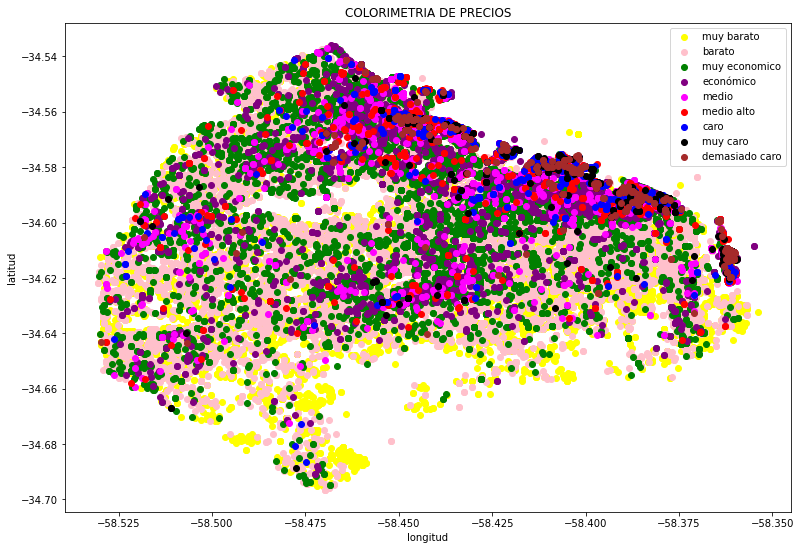

In [19]:
# creamos un DataFrame nuevo
df_plot=pd.DataFrame()

# Creamos un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtrado de cada clase con su color respectivo
    df_plot=dataset[dataset['color']==colors]
    #plotear los datos en una grafica de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # se crea un nuevo dataFrame en cada iteracion 
    df_plot=pd.DataFrame()
plt.title('COLORIMETRIA DE PRECIOS')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()


Predominan en la zona central y norte de la ciudad los inmuebles mas caros, presentando algunas zonas donde se mezclan los mas costosos con los de precio medio, en cambio los mas baratos están distribuidos hacia la parte sur, formando una especie de cordón hacia las perifierias de la ciudad, tal como sucede en muchas ciudades del continente. Esto es indicativo de que es posible entrenar un modelo de predicción (con un grado de confiabilidad aceptable) usando como atributos la longitud y latitud de cada inmueble. El modelo que se va a entrenar debe predecir los costos de los inmuebles en la mayoría de las zonas con una precisión aceptable, en caso contrario deben realizarse las acciones de filtrado y depuracion de datos que mejoren este desempeño.

### 5. Entrenar un nuevo modelo de Machine Learning  (intentando obtener una precisión superior al 50% al menos)

Vamos a proceder al escalado de los datos usando la tecnica de NORMALIZACION MEDIA, ya que es una de las formas más fáciles de normalizar los Dataframes de rangos variados. Esto , se hace restando la media y dividiendo por la desviación estándar para todos los elementos del Dataframe.

In [23]:
# Para eso se crea una pequeña funcion que nos hace esa tarea
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

#dataset2 es el mismo dataset sin la columna de rango porque este no es un atributo para entrenar el modelo
dataset2 = dataset.drop(['rango'], axis=1) #esto quita a la columna rango que noes numerica

#dataset2 es el mismo dataset sin la columna de color porque solo requerimos los atributos latitud y longitud
dataset2 = dataset2.drop(['color'], axis=1) #esto quita a la columna rango que no es numerica

#Ahora se usa la funcion creada para normalizar el nuevo dataset
dataset_norm = mean_norm(dataset2)

print('----Dataset normalizado------')
print(dataset_norm.head())

----Dataset normalizado------
        lat       lon     price
0 -0.272268  1.420349 -0.422615
1 -1.030205  0.670210 -0.388077
2  0.241096  0.245890 -0.583792
3  0.752963 -0.010409  0.394781
5  0.232336 -0.134270 -0.439884


Vamos a separar el dataset normalizado en un conjunto de entrenamiento (80%) y un conjunto de test (20%).

In [24]:
# Se separa el dataset en X_train, X_test, y_train e y_test con el tamaño correspondiente
X = dataset_norm.drop(['price'], axis=1) #esto quita a la columna target
y = dataset_norm['price']                #esta es la columna target

# Se realiza la separación a continuación del conjunto de entrnamiento
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2)

# Se imprimen las dimensiones de los conjuntos creados
print("Train test size: ", X_train.shape)
print("Test train size: ", X_test.shape)

Train test size:  (69288, 2)
Test train size:  (17322, 2)


En esta parte vamos a Instanciar el modelo de estimacion o algoritmo que vamos a entrenar , en este caso se trata del algoritmo RandomForestRegressor. Hemos seleccionado este modelo porque necesitamos hacer una regresión (ya que nuestro target es una variable numero continua tipo float) y además la literatura y consultas realizadas en la web evidencia que es uno de los algoritmos que mejor desempeño tiene cuando trabajamos con porcos atributos como es nuestro caso que solo tenemos 2 atributos.

In [25]:
# Creamos elobjeto o clase 
random_forest_model = RandomForestRegressor() # Instanciar el modelo de estimacion

# usamos el metodo fit para entrenar
random_forest_model.fit(X_train , y_train) # Entrenando




RandomForestRegressor()

Vamos ahora a validar nuestro modelo.  Para validar Se toma como entrada el número de diferentes divisiones (pliegues) que se utilizarán (5 en el ejemplo a continuación) y se imprimen el parametro score que indica la calidad que tendremos en la prediccion.

In [26]:
# Se calcula el score
scores_random_forest = cross_val_score(random_forest_model, X, y, cv=5)

print(' ')
print(' Los resultados de la validacion cruzada para Random Forest es: ')
print(scores_random_forest)
print ("Accuracy_ Random Forest: %0.2f (+/- %0.2f)" % (scores_random_forest.mean(), scores_random_forest.std() / 2))

# Vamos a guardar el score de este modelo en la siguiente variable para despuesta compararlo con otro mejorado
score_modelo1=scores_random_forest.mean()


 
 Los resultados de la validacion cruzada para Random Forest es: 
[0.65994762 0.67342466 0.65674581 0.61400999 0.71482038]
Accuracy_ Random Forest: 0.66 (+/- 0.02)


### 6. Evaluar el cambio en el error relativo % a medida que se optimiza algún hiperparametro 

Hemos obtenido una precisión superior a la esperada por lo tanto puede utilizarse el modelo entrenado para predecir el precio de cualquier inmueble en la ciudad. Antes de realizar la Predicción , chequearemos los errores relativos. Para ello, primero vamos a crear una funcion que nos permita transformar los datos normalizados a la escala real en pesos o unidad monetaria, para ello creamos la siguiente funcion.

In [27]:
#funcion para desnormalizar los valores y poder llevarlos a pesos Argentinos
def desnorm(dato_norm):
    desviacion=dataset2['price'].std()
    media=dataset2['price'].mean()
    dato_desnorm=dato_norm*desviacion+media
    return dato_desnorm #retorna el array en valores monetarios


Ahora evaluaremos el cambio en el error relativo a medida que es más profundo el bosque, tanto en training como en testing.

Para esto, se itera de 5 en 5  en el parámetro max_depth y vemos que sucede con el error relativo.
Aqui primero crearemos dos listas donde vamos a ir guardando los errores tanto del conjunto de entrenamiento como el de testeo

In [28]:
error_train = []
error_test= []

Definimos una lista con los valores deprofundidad que queremos optimizar

In [29]:
depth =  [p for p in range(5,65,5)]

Iteramos sobre la lista anterior y vamos calculando los errores de prediccion en cada caso

In [30]:
for value in depth:
    
    #asigna las profundidades al modelo
    modelo = RandomForestRegressor(max_depth=value)
    
    #entrena el modelo   
    modelo.fit(X_train, y_train) 
    
    ## Para el conjunto de testeo    
    #prediccion para X_test
    y_pred_test = modelo.predict(X_test) 
    #Se transforman los datos a unidades monetarias
    y_pred_moneda=np.array(desnorm(y_pred_test))
    #Se transforman los datos de testeo originales que habiamos normalizados a unidades monetarias
    y_test_moneda=desnorm(y_test)   
    # Se calcula el error relativo
    error_relativo_test=np.array(100*abs(y_test_moneda-y_pred_moneda)/y_test_moneda)
    # Se calcula el valor medio de los errores
    error_medio_test=error_relativo_test.mean()
    #agrega la información a las listas de arriba
    error_test.append(error_medio_test)
    
    ## Para el conjunto de entrenamiento
    #predice sobre X_train, 
    y_pred_train = modelo.predict(X_train)
    #Se transforman los datos a unidades monetarias
    y_pred_moneda=np.array(desnorm(y_pred_train))
    #Se transforman los datos de entrenamiento originales que habiamos normalizados a unidades monetarias
    y_train_moneda=desnorm(y_train)
    # Se calcula el error relativo
    error_relativo_train=np.array( 100*abs (y_train_moneda-y_pred_moneda)/y_train_moneda ) 
    error_medio_train=error_relativo_train.mean()    
    #agrega la información a las listas de arriba    
    error_train.append(error_medio_train) #a

Ahora que tenemos las listas de errores para cada conjunto de entrenamiento podemos graficar el error y decidir cual es el valor optimo del parametro "depth" del modelo. Esto se nota claramente cuando la grafica de errores tiende a estabilizarse.

Aqui hacemos el código para graficar 

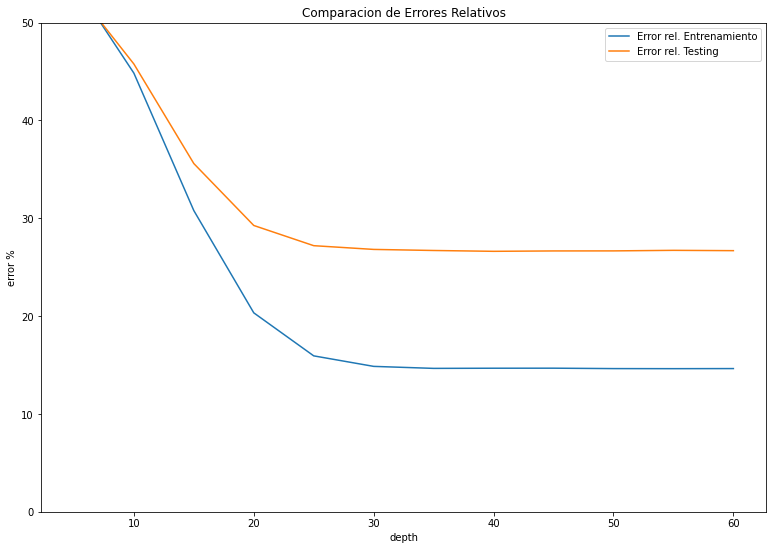

In [31]:
plt.plot(range(5,65, 5), error_train, label='Error rel. Entrenamiento')
plt.plot(range(5,65, 5), error_test, label='Error rel. Testing')
plt.ylim((0, 50))
plt.legend(loc="best")
plt.title("Comparacion de Errores Relativos")
plt.xlabel('depth')
plt.ylabel('error %')
plt.show()

Observando la grafica de errores , asumimos que la profundidad "depth" optima del modelo es de 60, por eso este sera nuestro nuevo modelo.

In [32]:
modelo = RandomForestRegressor(max_depth=60)


### 7. ¿Cómo es la distribución espacial de los errores de predicción? Explíquelo gráficamente

Ya tenemos una precisión superior a la esperada y también hemos optimizado el valor de la profunidad del modelo, por lo tanto, solo falta analizar como se distribuyen los errores en cada una de las zonas del mapa. En tal sentido, vamos a entrenar nuestro modelo definitvo optimizado y calculemos los errores relativos que se cometen cuando se predicen todo el conjunto original completo. Para lograrlo, debemos crear dos columnas nuevas en nuestro dataFrame.


Entrenamos el modelo una vez mas 

In [33]:
modelo.fit(X,y)

RandomForestRegressor(max_depth=60)

Creamos la columna de precios predichos y de una vez los convertimos a unidades monetarias

In [34]:
dataset2['price_predict']= desnorm(modelo.predict(X)) 


Ahora procedemos a crear una columna llamada error relativo que contenga los errores de prediccion del conjunto

In [35]:
dataset2['error %']= abs(dataset2['price_predict']-dataset2['price'])*100/dataset2['price']

veamos como queda nuestro DataFrame

In [36]:
dataset2.head()

lat        lon     price  price_predict       error %
0 -34.605880 -58.384949  153000.0  151429.611250  1.026398e+00
1 -34.624056 -58.412110  159000.0  172055.000000  8.210692e+00
2 -34.593569 -58.427474  125000.0  125000.000000  1.164153e-13
3 -34.581294 -58.436754  295000.0  278331.969697  5.650180e+00
5 -34.593779 -58.441239  150000.0  150000.000000  7.761021e-14

Para dar una explicacion grafica vamos a representar en un mapa de dispersión los errores en cada zona de la Provincia. Aplicaremos el mismo procedimiento que usamos en el mapa de colores que ya hicimos con anterioridad

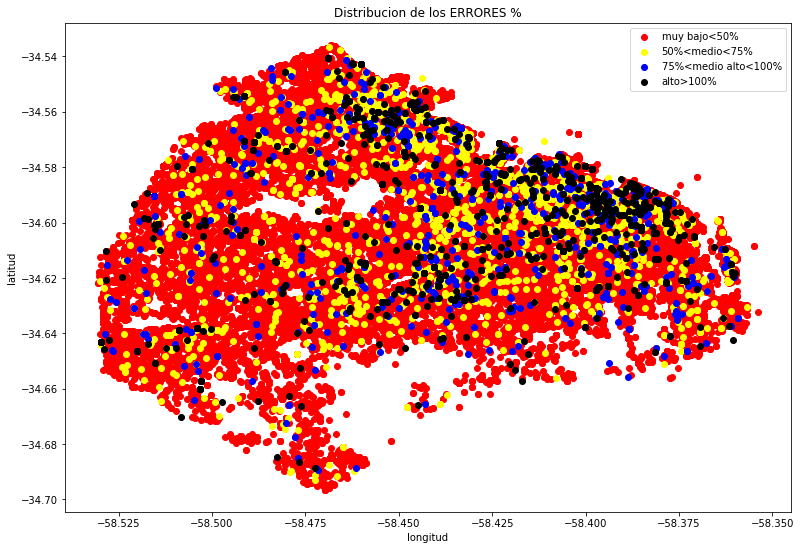

In [37]:
# creamos la lista con los rangos limites para cada intervalo
bins=[0,50,75,100,200]# int for int in range(0,int(dataset2['error %'].max()), int(espaciado)) ]
# Agrupe las etiquetas correspondientes
etiquetas = ['muy bajo<50%', '50%<medio<75%', '75%<medio alto<100%', 'alto>100%']
# para graficar se usaran la siguiente lista de colores 
colores=['red','yellow','blue','black'] 
# Definir rangos  como una nueva columna 
dataset2 ['rango'] = pd.cut ( dataset2['error %'], bins,
        right=False, labels=etiquetas)
# Definir una nueva columna que contiene el color para cada precio
dataset2 ['color'] = pd.cut ( dataset2['error %'], bins,
        right=False, labels=colores)
df_plot=pd.DataFrame()
# Creamos un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtrado de cada clase con su color respectivo
    df_plot=dataset2[dataset2['color']==colors]
    #plotear los datos en una grafica de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # se crea un nuevo dataFrame en cada iteracion 
    df_plot=pd.DataFrame() 
plt.title('Distribucion de los ERRORES %')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()



Podemos ver que existen zonas donde el error es muy bajo es decir menor al 50% y otras zonas donde el error es medio alto , es decir, esta en el intervalo 50% - 100%.
Ademas se aprecia que existen zonas con alto porcentajes de errores relativos lo cual hace presumir que el modelo no es capaz de predecir el precio de los inmuebles en esas zonas. Se recomienda realizar algunas modificaciones al dataset usado como entrenamiento, a fin de crear un nuevo modelo de predicción con una presición un poco mayor a la obtenida en este modelo.


###  6. ¿Hay alguna estrategia adicional para mejorar la precisión del modelo y reducir el error de predicción ?

La estrategia propuesta consta de filtrar aquellos puntos o propiedades que presentan un error de prediccion alto o mayor al 50%. Vamos a crear un nuevo DataFrame solo con los puntos que entren en ese criterio y asumiremos que ese es nuestro nuevo dataset para entrenar nuestro modelo de nuevo.

In [38]:
# creamos el modelo optimizado
modelo_opt = RandomForestRegressor(max_depth=60)
# filtrar puntos con error menor a 50%
df2=dataset2[dataset2['error %']<50]
df3=df2.copy() #creamos una copia de este dataframe 
# lista quer contiene las columnas a eliminar del d
columnas_eliminar=['price_predict','error %','rango','color']
# ciclo para ir eliminando cada columna que no queremos tener una por una
for col in columnas_eliminar:
    data_final = df2.drop([col], axis=1) #esto quita a la columna target
    df2=data_final
# eliminamos el precio para tener a X train
X = data_final.drop(['price'], axis=1)
# definimos el target
y=data_final['price']
# entrenamos el modelo con este nuevo datasets de puntos con bajo error
modelo_opt.fit(X,y)

RandomForestRegressor(max_depth=60)

Volvemos a Calcular el Score

In [39]:
# Se calcula el score
scores_random_forest = cross_val_score(modelo_opt, X, y, cv=5)

print(' ')
print(' Los resultados de la validacion cruzada para Random Forest es: ')
print(scores_random_forest)
print ("Accuracy_ Random Forest: %0.2f (+/- %0.2f)" % (scores_random_forest.mean(), scores_random_forest.std() / 2))
# Vamos a guardar el score de este modelo en la siguiente variable para despuesta compararlo con otro mejorado
score_modelo2=scores_random_forest.mean()


 
 Los resultados de la validacion cruzada para Random Forest es: 
[0.74981939 0.76542629 0.73820967 0.69528894 0.79050665]
Accuracy_ Random Forest: 0.75 (+/- 0.02)


Vamos a hacer una grafica de Barras que demuesra la mejora en el score entre los dos modelos

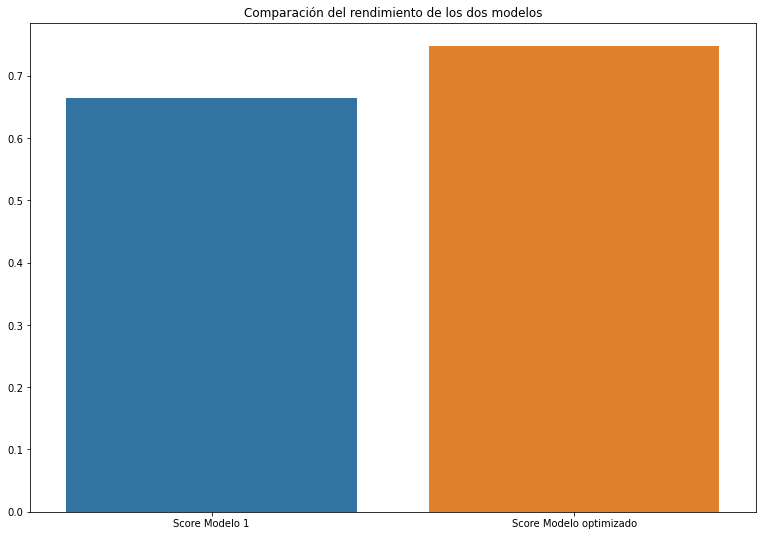

In [40]:
x = ['Score Modelo 1', 'Score Modelo optimizado']
y = [score_modelo1, score_modelo2]

#Se genera la grafica de barras
sns.barplot(x, y).set_title('Comparación del rendimiento de los dos modelos')

plt.show()

Vemos que la precisión es mucho mejor ya que se incremento al 74%, vamos ahora a generar las nuevas columnas de predicción y de cálculo de los nuevos errores relativos con el nuevo dataset.

In [41]:
# nueva columna con los valores predichos con el nuevo modelo mejorado
df3['price_predict_2']= (modelo_opt.predict(X)) 
# nueva columna con los valores del error relativoredichos con el nuevo modelo mejprado
df3['error 2 %']= abs(df3['price_predict_2']-df3['price'])*100/df3['price']
df3.head()

lat        lon     price  price_predict       error %         rango  \
0 -34.605880 -58.384949  153000.0  151429.611250  1.026398e+00  muy bajo<50%   
1 -34.624056 -58.412110  159000.0  172055.000000  8.210692e+00  muy bajo<50%   
2 -34.593569 -58.427474  125000.0  125000.000000  1.164153e-13  muy bajo<50%   
3 -34.581294 -58.436754  295000.0  278331.969697  5.650180e+00  muy bajo<50%   
5 -34.593779 -58.441239  150000.0  150000.000000  7.761021e-14  muy bajo<50%   

  color  price_predict_2  error 2 %  
0   red    149930.000000   2.006536  
1   red    165370.000000   4.006289  
2   red    125000.000000   0.000000  
3   red    281413.684211   4.605531  
5   red    150000.000000   0.000000

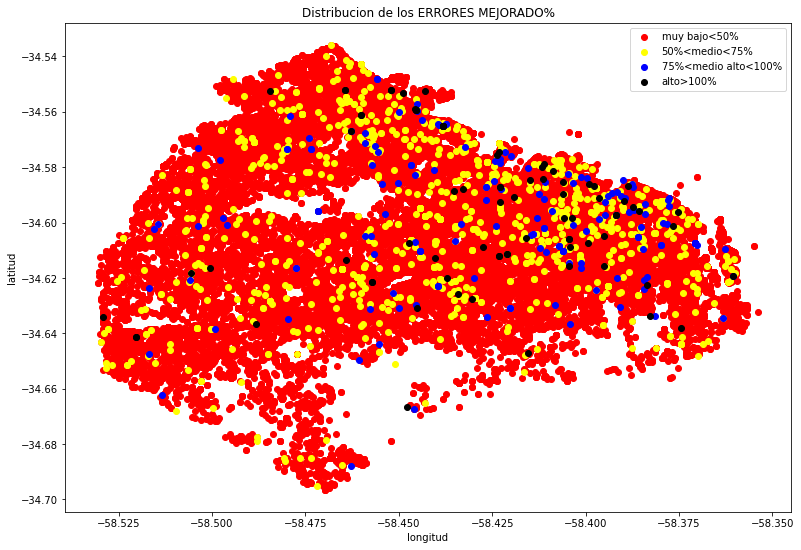

In [42]:
# creamos la lista con los rangos limites para cada intervalo
bins=[0,50,75,100,200]# int for int in range(0,int(dataset2['error %'].max()), int(espaciado)) ]
# Agrupe las etiquetas correspondientes
etiquetas = ['muy bajo<50%', '50%<medio<75%', '75%<medio alto<100%', 'alto>100%']
# para graficar se usaran la siguiente lista de colores 
colores=['red','yellow','blue','black'] 
# Definir rangos  como una nueva columna 
df3 ['rango2'] = pd.cut ( df3['error 2 %'], bins,
        right=False, labels=etiquetas)
# Definir una nueva columna que contiene el color para cada precio
df3 ['color2'] = pd.cut ( df3['error 2 %'], bins,
        right=False, labels=colores)
df_plot=pd.DataFrame()
# Creamos un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtrado de cada clase con su color respectivo
    df_plot=df3[df3['color2']==colors]
    #plotear los datos en una grafica de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # se crea un nuevo dataFrame en cada iteracion 
    df_plot=pd.DataFrame() 
plt.title('Distribucion de los ERRORES MEJORADO%')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()



Claramente se observa una reducción sustancial de la distribución de los errores, predominando los colores rojo y amarillo, lo cual quiere decir que este nuevo modelo depurado y optimizado ofrece mejor desempeño para predecir el precio de cualquier propiedad en Ciudad Capital. Adicionalmente, se han depurado muchos de los puntos negros y azules que aparecian en la gráfica del modelo anterior, los cuales representaban errores muy altos.

###  7. ¿Cuál sería el precio referencial de las propiedades que se planifiquen en las siguientes zonas?
Punto A (longitud=-58.526, Latitud=-34.626) y Punto B (longitud=-58.377, Latitud=-34.633)

Para calcular el precio de estas propiedades, simplemente creamos un DataFrame con las coordenadas que nos dan en cada caso (A y B) y esa será nuestra x a predecir con el modelo optimizado

In [43]:
#Para el punto A
xA=pd.DataFrame()
# Vaciamos las coordenadas de A
xA['lat']=[-34.626]
xA['lon']=[-58.526]

In [44]:
# hacemos la prediccion con el modelo optimizado
yA=modelo_opt.predict(xA)
print('El precio de la propiedad A es de:', int(yA[0]), ' pesos')


El precio de la propiedad A es de: 312747  pesos


In [45]:
#Para el punto B
xB=pd.DataFrame()
# Vaciamos las coordenadas de A
xB['lat']=[-34.633]
xB['lon']=[-58.377]

In [46]:
# hacemos la prediccion con el modelo optimizado
yB=modelo_opt.predict(xB)
print('El precio de la propiedad B es de:', int(yB[0]), ' pesos')


El precio de la propiedad B es de: 278191  pesos
